In [1]:
from tqdm import tqdm_notebook, tqdm
import pandas as pd
from os.path import join as oj
import sys, time
import matplotlib.pyplot as plt
import os
import csv
import numpy as np
import pickle as pkl
import seaborn as sns
sns.set()
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
results_folder = "../results"
fnames = sorted([oj(results_folder, fname) for fname in os.listdir(results_folder) if 'sort' in fname]) # filenames in the directory
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in tqdm(fnames) ] 
results = pd.concat(results_list, axis=1).T.infer_objects() # pandas dataframe w/ hyperparams and weights stored
results["final_acc"] = [max(x) for x in results["acc_test"]]
results["min_test_loss"] = [x[-1]for x in results["losses_test"]]
results["num_epochs"] = [len(x) for x in results["losses_test"]]
results["min_train_loss"] = [min(x) for x in results["losses_train"]]
#results = results[ results.duplicated(subset = ['repeats','learning_rate', 'num_noise_chars','noise', 'num_in_train', 'num_neurons','weight','num_epochs','string_length'],keep ='last') == False]


100%|██████████| 54/54 [00:00<00:00, 75.65it/s]


In [3]:
results.groupby(['weight']).mean()[['final_acc','min_train_loss', 'min_test_loss' ]].sort_values(by=['weight'])

,final_acc,min_train_loss,min_test_loss
weight,,,
0.0,76.222222,0.000007,2.750280
0.1,81.944444,0.001033,1.242885
1.0,89.888889,0.001832,0.418327


In [4]:
results = results[results.weight !=0.1]

In [5]:
# get accuracy diff between two
grouped_pairs = results[results.weight != 0.1].groupby(['string_length', 'repeats', 'num_in_train','noise','num_neurons', 'num_epochs','num_noise_chars'])
best_diff = -100
best_pair  = None
for  group_name, group in grouped_pairs:

    if len(group )>1:  
        first_is_regularized = (group.weight.iloc[0] -group.weight.iloc[1]) >0
        curr_acc_diff = -((group.final_acc.iloc[0] - group.final_acc.iloc[1]))
        if first_is_regularized:
            curr_acc_diff = - curr_acc_diff
        if curr_acc_diff > best_diff:
            best_diff = curr_acc_diff
            best_pair = group_name
print(best_diff)

27.0


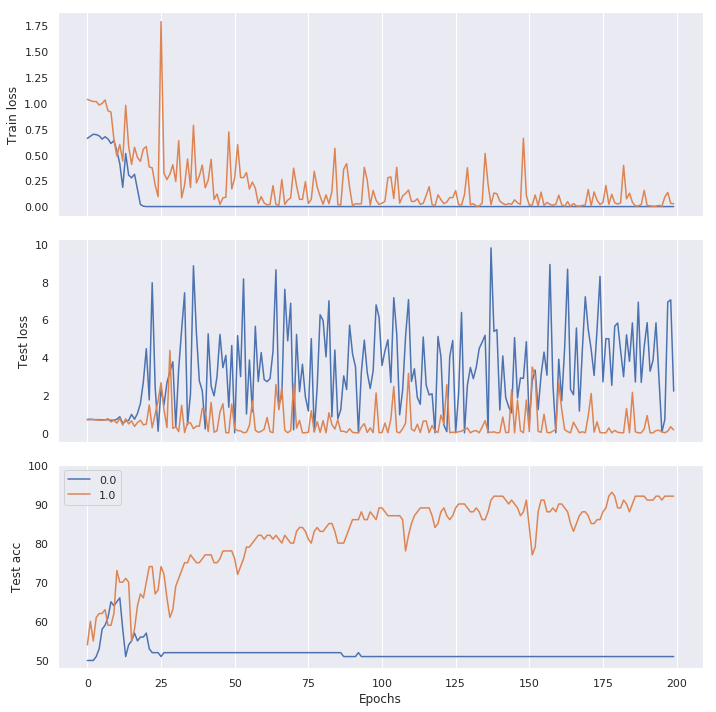

In [6]:
f, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
for idx, line in results.iterrows():

    if   line["num_in_train"] ==best_pair[2] and  line['string_length'] == best_pair[0] and  line['noise'] ==best_pair[3]and  line['num_epochs'] ==best_pair[5]:        
        axes[0].plot(line["losses_train"])
        axes[1].plot(line["losses_test"])
        axes[2].plot(line["acc_test"], label = line["weight"])
axes[0].set_ylabel("Train loss")
axes[2].set_xlabel("Epochs")
axes[0].grid( axis='y')
#axes[0].set_ylim([0, 1])
plt.legend();
axes[1].set_ylabel("Test loss")
axes[1].grid( axis='y')
# axes[1].set_ylim([0, .01])
axes[2].set_ylabel("Test acc")
axes[2].set_ylim([48, 100])
axes[2].grid( axis='y')
plt.tight_layout()
plt.legend();